# Plotting with hockey_rink

In this notebook, we'll look at examples of how to draw plots on rinks using the hockey_rink package. This'll work best if we have some real world data to work with. We'll grab some whockey data from the Big Data Cup and some NHL data from SportsDataverse.

In [3]:
from hockey_rink import NHLRink
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
bdc_url = (
    "https://raw.githubusercontent.com/the-bucketless/bdc/refs/heads/main/data/"
    "pxp_womens_oly_2022_v2.csv"
)

bdc_pbp = pd.read_csv(bdc_url)

In [5]:
nhl_url = (
    "https://github.com/sportsdataverse/fastRhockey-data/blob/main/nhl/pbp/"
    "parquet/play_by_play_2023.parquet?raw=true"
)

nhl_shots = (
    pd.read_parquet(nhl_url)
    .query("event_type in ('GOAL', 'SHOT', 'MISS')")
    .assign(
        is_goal=lambda df_: df_.event_type == "GOAL",

        # For simplicity, assuming every shot comes from the ozone
        y=lambda df_: df_.y * np.sign(df_.x),
        x=lambda df_: np.abs(df_.x),
    )
)

## .plot()

We'll start by simply plotting a line. There are two ways to draw the rink we want our purple line on. The first is to explicitly call the `draw` method.

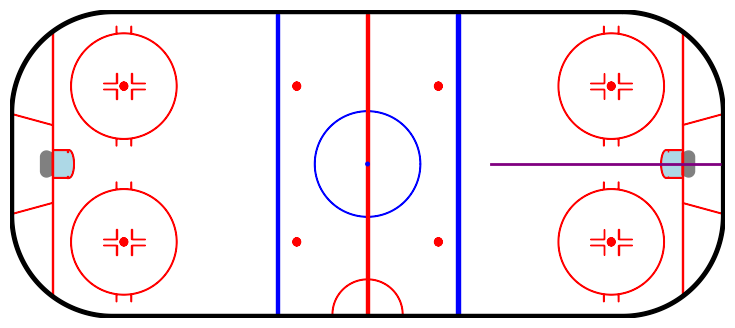

In [6]:
rink = NHLRink()

x = [35, 110]
y = [0, 0]

ax = rink.draw(figsize=(10, 4))
rink.plot(
    x, y,
    linewidth=2, color="purple", zorder=101,
)
plt.show()

The other is to ignore the `draw` method and go straight to plotting. If we still want to pass parameters to `draw`, we can pass them to `draw_kw`.

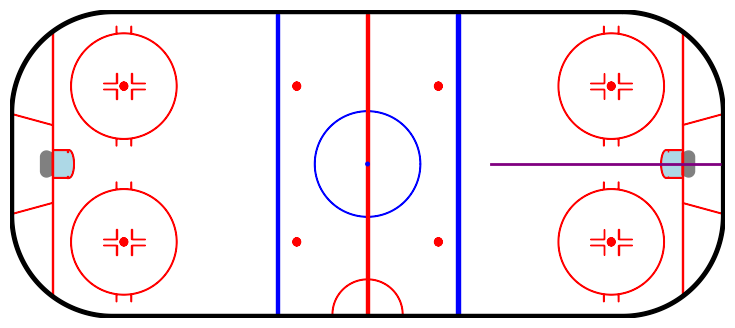

In [7]:
rink.plot(
    x, y,
    linewidth=2, color="purple", zorder=101,
    draw_kw={"figsize": (10, 4)},
)
plt.show()

You may have noticed the line we're plotting is supposed to be going outside the rink. By default, plotting methods will clip anything happening outside the rink. If we want to allow plots to exit the rink, we have to set `clip_to_boards=False`.

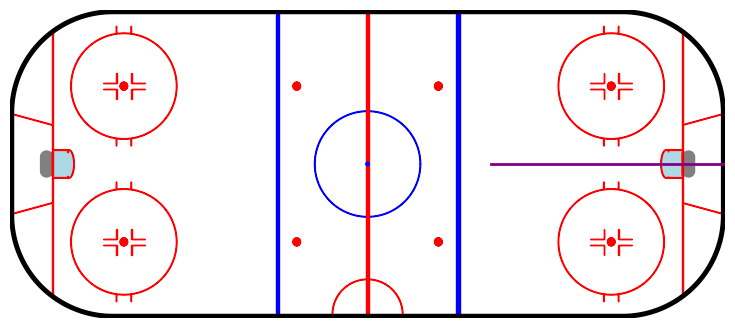

In [8]:
rink.plot(
    x, y,
    linewidth=2, color="purple", zorder=101,
    draw_kw={"figsize": (10, 4)},
    clip_to_boards=False,
)
plt.show()

This still doesn't show the complete line. For that, we also need to allow the package to update the display range based on the data we're giving it.

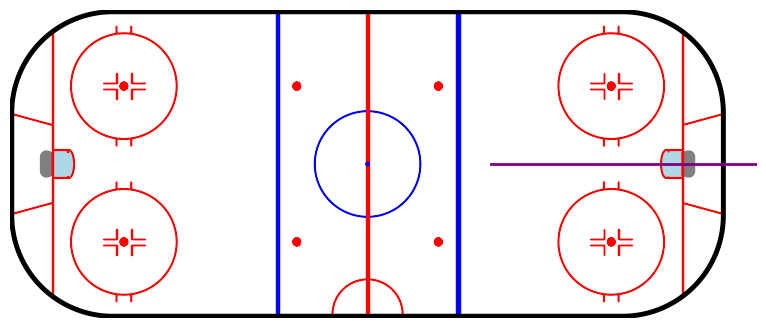

In [9]:
rink.plot(
    x, y,
    linewidth=2, color="purple", zorder=101,
    draw_kw={"figsize": (10, 4)},
    clip_to_boards=False,
    update_display_range=True,
)
plt.show()

If we want to test what something would look like without the rink, we can tell the plotting function to skip the whole drawing thing. This can be a faster way to test some plots before seeing what they look like on the rink.

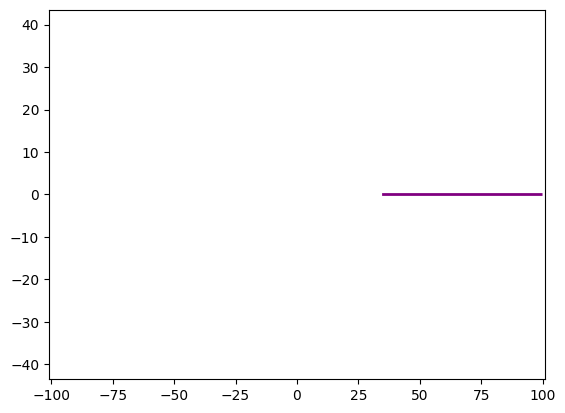

In [10]:
fig, ax = plt.subplots()
rink.plot(
    x, y,
    linewidth=2, color="purple", zorder=101,
    skip_draw=True,
)
rink.set_display_range()
plt.show()

## .scatter()

OK, we should be ready for something more than a line. Probably the most common rink plots to be found are shot charts. These can be made easily with a scatter plot. So let's grab some shots from the BDC data. For this, we'll look at the Canada-USA game.

In [11]:
RINK_LENGTH = 200
RINK_WIDTH = 85

teams = ("Olympic (Women) - Canada", "Olympic (Women) - United States")

In [12]:
canada_usa_shots = (
    bdc_pbp
    .query(
        "event == 'Shot'"
        " and team_name in @teams"
        " and opp_team_name in @teams"
    )
)

All right, let's see some shots.

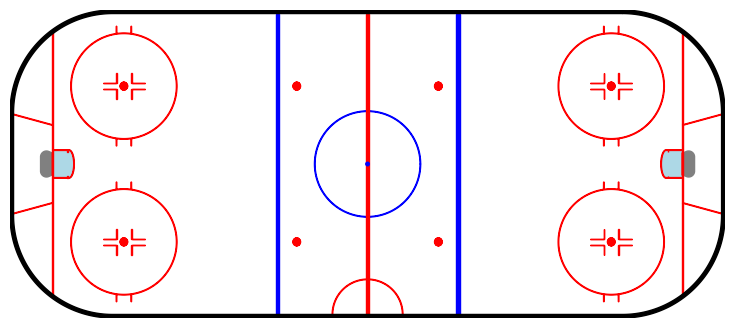

In [13]:
rink.scatter(
    x=canada_usa_shots.x_coord,
    y=canada_usa_shots.y_coord,
    draw_kw={"figsize": (10, 4)},
)
plt.show()

Well that's not what we wanted. The BDC data is recorded with x-coordinates ranging from 0 to 200 and y-coordinates from 0 to 85. By default, the rink assumes a (-100, 100) and (-42.5, 42.5) coordinate system. We can change this by setting the `x_shift` and `y_shift` parameters.

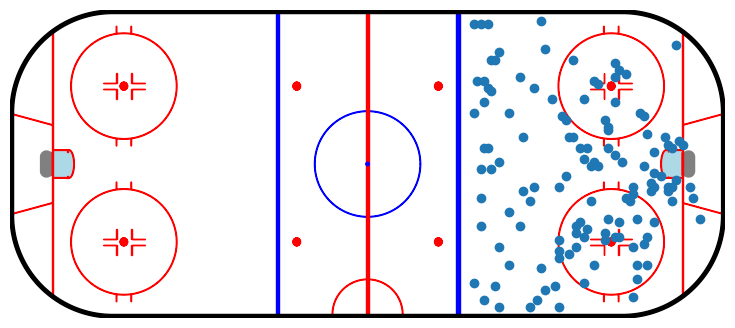

In [14]:
rink = NHLRink(x_shift=RINK_LENGTH / 2, y_shift=RINK_WIDTH / 2)

rink.scatter(
    x="x_coord", y="y_coord",
    data=canada_usa_shots,
    draw_kw={"figsize": (10, 4)},
)

plt.show()

That's a little better, but it doesn't show us which team's getting shots from where. So let's update the data to mirror one team's shots to the other side of the rink and give each team a distinct color.

In [15]:
canada_usa_shots = (
    canada_usa_shots
    .assign(
        x=lambda df_: df_.x_coord.mask(df_.team_name == teams[1], RINK_LENGTH - df_.x_coord),
        y=lambda df_: df_.y_coord.mask(df_.team_name == teams[1], RINK_WIDTH - df_.y_coord),
        color=lambda df_: df_.team_name.map({teams[0]: "red", teams[1]: "blue"}),
    )
)

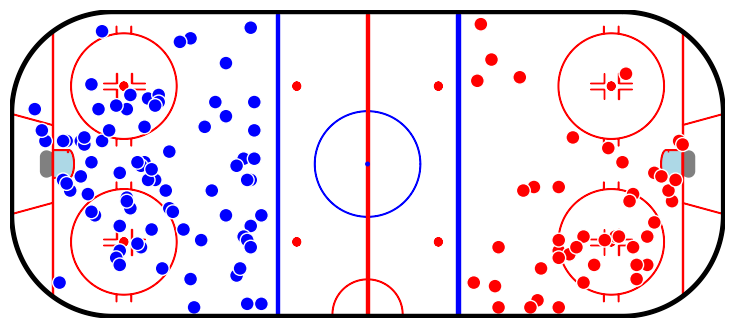

In [16]:
rink.scatter(
    x="x", y="y",
    color="color",
    data=canada_usa_shots,
    edgecolor="white",
    s=100,
    draw_kw={"figsize": (10, 4)},
)

plt.show()

We can also focus in on the offensive zone with a couple side-by-side ozone plots.

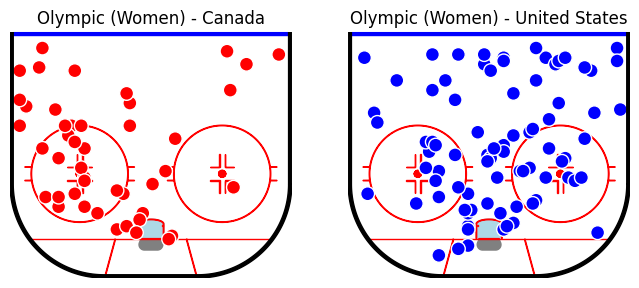

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

for team, ax in zip(teams, axs):
    rink.scatter(
        # Back to using the default coordinates, not the flipped.
        "x_coord", "y_coord",
        color="color",
        data=canada_usa_shots.query("team_name == @team"),
        edgecolor="white",
        s=100,
        draw_kw={"display_range": "ozone", "rotation": 270},
        ax=ax,
    )
    ax.set_title(team)

## .arrow()

Next up, let's check out some arrow plots. This time we'll show where Finland's powerplay passes were made.

In [18]:
finland_pp_passes = (
    bdc_pbp
    .query(
        "team_name == 'Olympic (Women) - Finland'"
        " and event == 'Play'"
        " and situation_type == '5 on 4'"
    )
    .dropna(subset=["frame_id_1"])
)

Unlike Matplotlib, the rink package allows for multiple arrows to be passed in at once. Matplotlib wants the distance the arrows are going (`dx` and `dy`) so we'll make a calculation to get that.  

Also note that we're able to pass in some data (`x` and `y`) from the DataFrame and other data (`dx` and `dy`) as values.

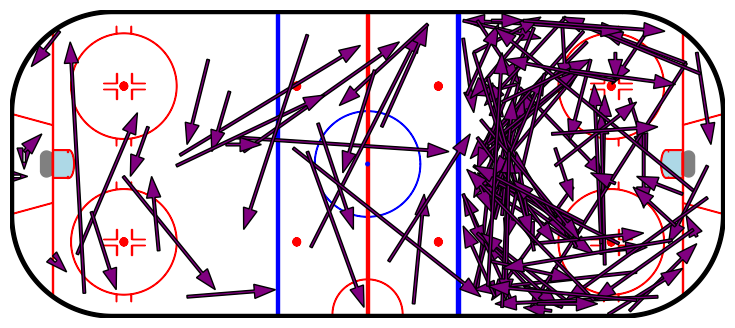

In [19]:
rink.arrow(
    x="x_coord", y="y_coord",
    dx=finland_pp_passes.x_coord_2 - finland_pp_passes.x_coord,
    dy=finland_pp_passes.y_coord_2 - finland_pp_passes.y_coord,
    data=finland_pp_passes,
    facecolor="purple", edgecolor="black",
    head_width=4, length_includes_head=True,
    draw_kw={"figsize": (10, 4)},
)
plt.show()

Having to make the calculations for distance travelled isn't ideal. Fortunately, the package also allows for arrows to be entered by their endpoints using `x2` and `y2`.

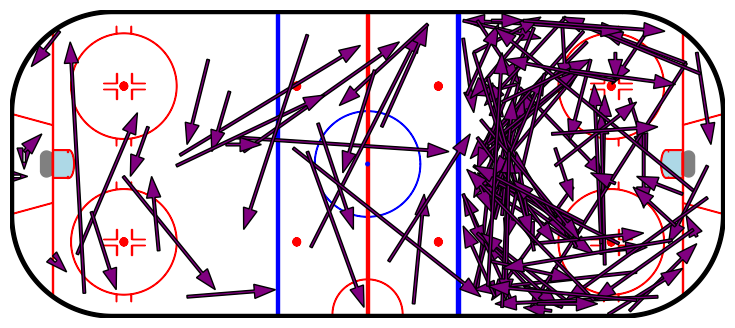

In [20]:
rink.arrow(
    x="x_coord", y="y_coord",
    x2="x_coord_2", y2="y_coord_2",
    data=finland_pp_passes,
    facecolor="purple", edgecolor="black",
    head_width=4, length_includes_head=True,
    draw_kw={"figsize": (10, 4)},
)
plt.show()

## .wavy_arrow()

In addition to the standard arrows, the package also makes some arrows with a wavy line for a shaft. This is commonly used to display player movement in diagrams.  

Like `.arrow()`, these can be made using either the distances or the endpoints.

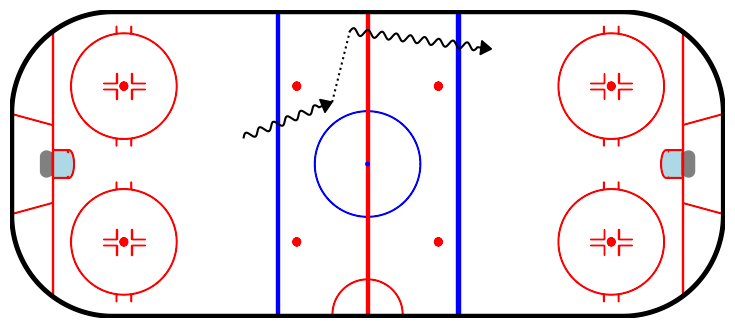

In [21]:
# Zone exit using x2 and y2.
rink.wavy_arrow(65, 50, x2=90, y2=60, draw_kw={"figsize": (10, 4)})

# Passing to the left with the plot method.
# With the rink already drawn, no longer have to worry about the figsize.
rink.plot([90, 95], [60, 80], ":", color="black")

# Zone entry using dx and dy.
rink.wavy_arrow(95, 80, dx=40, dy=-5)

plt.show()

We can also make these wavy arrows outside of the rink package. Though, this only uses the distances and not the endpoints. We'll use this to check out some different options available with the arrows.

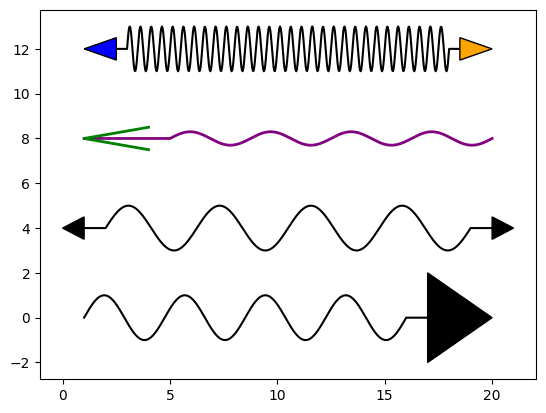

In [22]:
from hockey_rink.plotting import plot_wavy_arrow

# Bottom arrow, using the defaults.
plot_wavy_arrow(1, 0, 19, 0)

# 2nd lowest arrow.
plot_wavy_arrow(
    1, 4, 19, 0,

    # Add an arrowhead to the left side.
    has_left_head=True,

    # Change the size of the arrowhead.
    head_length=1, head_width=1,

    # Have the arrowhead go beyond the endpoint.
    length_includes_head=False,
)

# 2nd highest arrow.
plot_wavy_arrow(
    1, 8, 19, 0,
    has_left_head=True, has_right_head=False,
    head_width=1,

    # From closed arrowhead (-|>) to open (->).
    is_closed=False,

    # Change the height of the crest of the wave.
    wave_height=0.3,

    # Change the line thickness for the entire arrow.
    linewidth=2,

    # Change the color of the shaft of the arrow.
    shaft_kw={"color": "purple"},

    # Change the color of the arrowhead.
    head_kw={"color": "green"},
)

# Top arrow.
plot_wavy_arrow(
    1, 12, 19, 0,
    has_left_head=True,
    head_length=1.5, head_width=1,

    # Increase the number of waves.
    wave_frequency=2,

    # Shorten the stem that connects the wave to the arrowhead.
    stem_length=0.5,

    # Apply edgecolor to both arrowheads.
    head_kw={"edgecolor": "black"},

    # Change the facecolor of only the left arrowhead.
    left_head_kw={"facecolor": "blue"},

    # Change the facecolor of only the right arrowhead.
    right_head_kw={"facecolor": "orange"},
)

plt.show()

## .text()

We can also add some text to the rink. The most common use case for this would be showing player locations, often on top of a scatter plot.

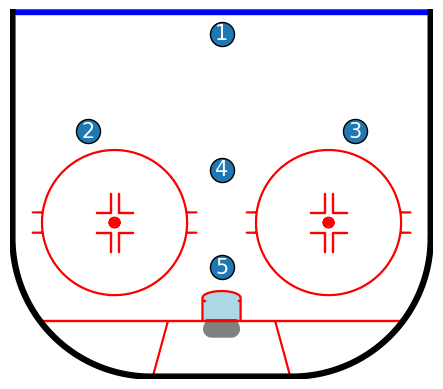

In [23]:
x = [130, 150, 150, 158, 178]
y = [42.5, 15, 70, 42.5, 42.5]

rink.scatter(
    x, y,
    s=300,
    edgecolor="black",
    draw_kw={"rotation": 270, "display_range": "ozone"},
)

rink.text(
    x, y, range(1, 6),
    color="white",
    ha="center", va="center",
    fontsize=15,
)

plt.show()

## Binned plots

There are three types of binned plots: `hexbin`, `heatmap`, and `contour` (or `contourf`). We'll use these to check out some shooting percentages. There aren't that many goals in the BDC data, so we'll switch to NHL data for this.  

The default parameters won't necessarily give what you're looking for with these.

In [24]:
nhl_rink = NHLRink(net={"visible": False})

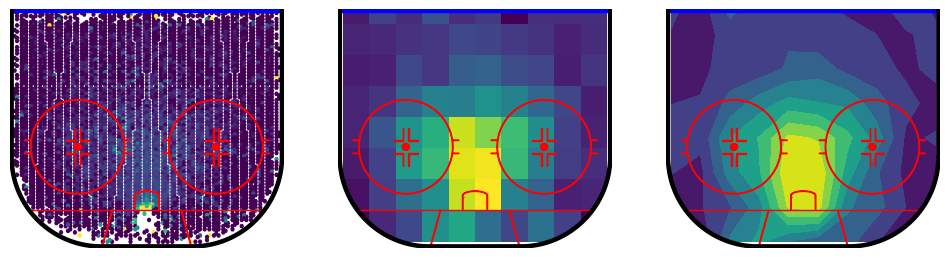

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

common_params = {
    "x": "x",
    "y": "y",
    "values": "is_goal",
    "data": nhl_shots,
    "draw_kw": {"display_range": "ozone", "rotation": 270},
}

nhl_rink.hexbin(ax=axs[0], **common_params)
nhl_rink.heatmap(ax=axs[1], **common_params)
nhl_rink.contourf(ax=axs[2], **common_params)

plt.show()

So let's try to make some improvements.

### .hexbin()

The most obvious way to improve the hexbin is to change up the `gridsize` to use larger bins. However, since this depends on Matplotlib's implementation, using the `gridsize` will include bins outside the rink's plotting region. To fix this, we'll have to use the `extent` parameter in Matplotlib's `hexbin`. Alternatively, we could update the data itself to avoid shots from outside the plotting region.

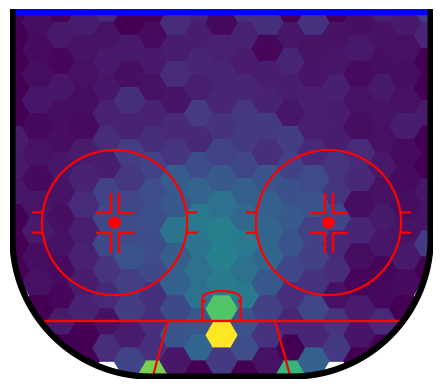

In [26]:
nhl_rink.hexbin(
    gridsize=(14, 9),
    extent=(25, 100, -42.5, 42.5),
    **common_params,
)

plt.show()

There are still a couple little bins at the bottom that are white from a lack of values. Matplotlib has a parameter for this (`mincnt`), however it doesn't play nice with the `C` parameter (what the rink package calls `values`).  

A workaround for this is to fill the plotting region with the lowest value from the colormap (Matplotlib's default is viridis). The rink package doesn't include `fill()` by default, but we can still make use of it with the `plot_fn()` function.

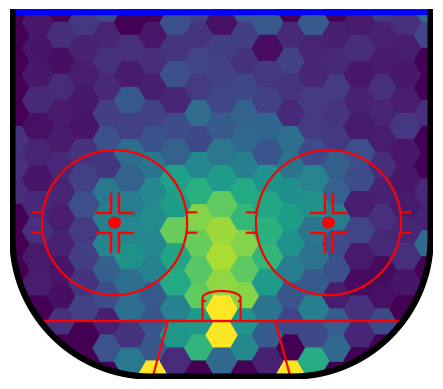

In [27]:
def plot_hexbin(ax=ax):
    nhl_rink.hexbin(
        gridsize=(14, 9),
        extent=(25, 100, -42.5, 42.5),
        vmax=0.25,
        ax=ax,
        **common_params,
    )

    min_color = plt.get_cmap("viridis")(0)

    half_length = RINK_LENGTH / 2
    half_width = RINK_WIDTH / 2

    nhl_rink.plot_fn(
        ax.fill,

        # Filling the entire rink for simplicity.
        x=[-half_length, half_length, half_length, -half_length],
        y=[-half_width, -half_width, half_width, half_width],

        color=min_color,
        zorder=2.5,

        # Matplotlib doesn't allow x and y to be passed as keyword parameters.
        # We get around this by telling plot_fn that they're positional
        # arguments.
        position_args=["x", "y"],
    )

fig, ax = plt.subplots()
plot_hexbin(ax)

### .heatmap()

Just as with the hexbin, the heatmap can be improved by changing up the size of the bins. For the heatmap, this can be done using the `binsize` parameter. There's also a `nbins` parameter if that's preferred or you can make your own bins and pass the values to `x` and `y`.  

For the heatmap, we'll focus on things happening above the goal line by setting `plot_xlim` and `plot_ylim`. We'll also change up the colormap to get some variety.

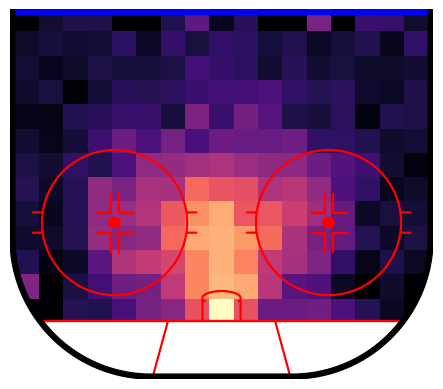

In [28]:
def plot_heatmap(ax):
    nhl_rink.heatmap(
        binsize=5,
        plot_xlim=(0, 89),
        plot_ylim=(-42.5, 42.5),
        cmap="magma",
        vmax=0.25,
        ax=ax,
        **common_params,
    )

fig, ax = plt.subplots()
plot_heatmap(ax)

### .contour() and .contourf()

There are two functions for contour plots, although they're really the same function with a different value for the `fill` parameter.

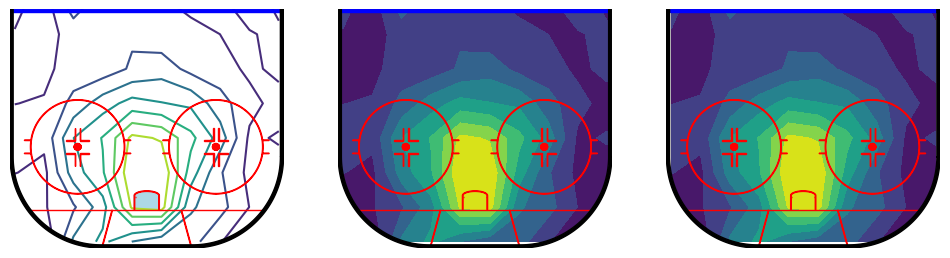

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

nhl_rink.contour(ax=axs[0], **common_params)
nhl_rink.contour(fill=True, ax=axs[1], **common_params)
nhl_rink.contourf(ax=axs[2], **common_params)

plt.show()

A common issue with a contour plot is that it won't extend to the extremes of the plotting region (see the white at the bottom of the above plots). For this reason, it's best to pass the desired region to `plot_range` the same way it's passed to `display_range` when drawing.  

Here we'll make use of the `nbins` instead of `binsize` and increase the number of `levels` in the contour plot, along with a new colormap.

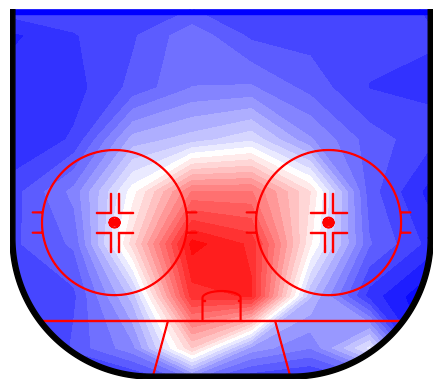

In [30]:
def plot_contourf(ax):
    nhl_rink.contourf(
        nbins=8,
        levels=30,
        plot_range="ozone",
        cmap="bwr",
        ax=ax,
        **common_params,
    )

fig, ax = plt.subplots()
plot_contourf(ax)

### Updated binned plots

Now, we can check out our updated plots side-by-side.

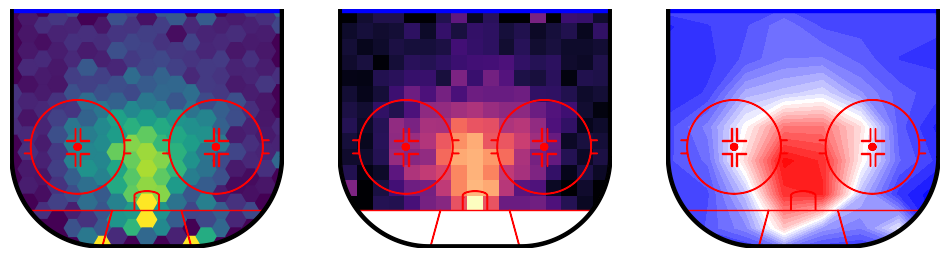

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_hexbin(ax=axs[0])
plot_heatmap(ax=axs[1])
plot_contourf(ax=axs[2])

plt.show()

## Seaborn

Finally, in addition to the plots provided by the package, we can try out some plots not provided. We've already seen this with the `fill` that we used on the hexbin. But we can go beyond that and even use some Seaborn plots.  

We can pass any plotting function we want to `plot_fn` and the package will try to figure out what we want from it. Not all plotting functions will work, but most sensible plots should work if entered correctly.  

Let's re-make the scatter plot we saw earlier using Seaborn's version.

In [32]:
import seaborn as sns

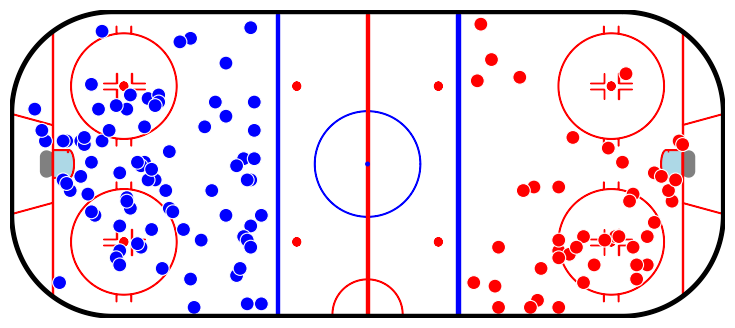

In [33]:
rink.plot_fn(
    sns.scatterplot,
    x="x", y="y",
    hue="team_name",
    palette=("red", "blue"),
    data=canada_usa_shots,
    s=100,
    legend=False,
    draw_kw={"figsize": (10, 4)},
)

plt.show()

And for our last plot, let's check out a KDE plot of where NHL shots typically come from.

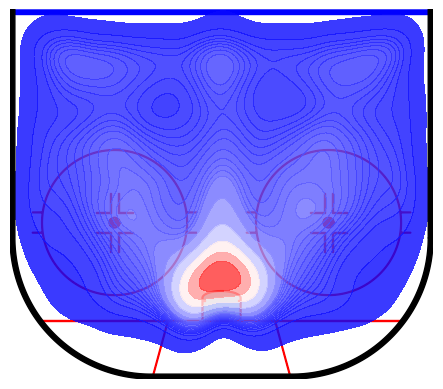

In [34]:
nhl_rink.plot_fn(
    sns.kdeplot,
    x="x", y="y",
    cmap="bwr", fill=True, alpha=0.8,
    levels=20,
    data=nhl_shots,
    draw_kw={"display_range": "ozone", "rotation": 270},
)
plt.show()